   # Answering Business Questions using SQL

## Introduction
In this project, we practice answering questions using SQLite and python. We are working with a database called Chinook.db that contains information about a fictional digital music shop. The database contains eleven tables with information about its employees, albums, artists, customers as well as customer purchases.

We will start by importing all the relevant modules and writing functions to run queries using context managers. This prevents any errors that may be caused by not properly closing connections to the database.

In [1]:
#!cp chinook-unmodified.db chinook.db

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

db = 'chinook.db'
#this function returns the query in a dataframe
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q,conn)

#this function is for executing queries that do not involve a table - e.g. CREATE VIEW
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        return conn.execute(c)

#this function returns a list of all tables and views in the database
def show_tables():
    q = '''SELECT name, type 
        FROM sqlite_master 
        WHERE type IN ("table", "view")'''
    return run_query(q)

print(show_tables())  

              name   type
0            album  table
1           artist  table
2         customer  table
3         employee  table
4            genre  table
5          invoice  table
6     invoice_line  table
7       media_type  table
8         playlist  table
9   playlist_track  table
10           track  table


## Selecting new albums to purchase
The Chinook record store has just signed a deal with a new record label, and our goal is to select the first three albums that will be added to the store, from a list of four.

| Name | Genre | 
| ----- | ------- | 
| Regal | Hip-Hop |
|Red Tone|Punk|
|Meteor and the Girls|Pop|
|Slim Jim Bites|Blues|

We will write a query to find out what genres of music sell the most tracks in the US and use that information to decide which 3 artists should be selected.

In [3]:
albums_to_purchase = '''WITH country_usa AS 
                        (
                        SELECT il.*
                        FROM invoice_line il
                        INNER JOIN invoice i ON i.invoice_id = il.invoice_id
                        INNER JOIN customer c ON c.customer_id = i.customer_id
                        WHERE c.country = "USA"
                        )
                        
       SELECT 
           g.name genre_name,  
           COUNT(c.invoice_line_id) tracks_sold, 
           (CAST(COUNT(c.invoice_line_id) AS Float)/
           (SELECT COUNT(*) FROM country_usa)) percent_sold
       FROM country_usa c
       INNER JOIN track t ON t.track_id = c.track_id
       INNER JOIN genre g ON g.genre_id = t.genre_id
       GROUP BY genre_name
       ORDER BY 2 DESC
       LIMIT 10;'''

run_query(albums_to_purchase)

,genre_name,tracks_sold,percent_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Pop,22,0.020932
7,Latin,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


Text(0, 0.5, '')

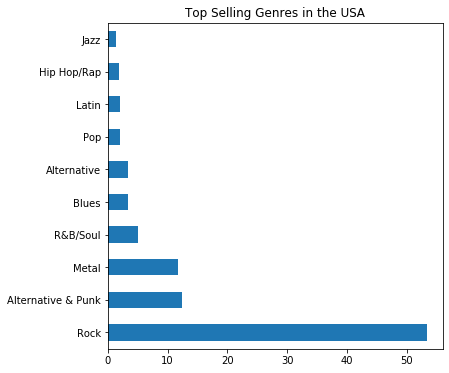

In [4]:
df = run_query(albums_to_purchase)
df = df.set_index('genre_name', drop=True)
df['percent_sold'] = df['percent_sold']*100
df['percent_sold'].plot.barh(figsize=(6,6), title='Top Selling Genres in the USA')
plt.ylabel('') #to supress y-axis label

Based on previous sales data, Chinook record store is recommended to buy albums from Red Tone (Punk), Slim Jim Bites (Blues) and Meteor and the Girls (Pop). Although, it would be ideal to find a records from the Rock genre which accounts for more than 53% of the total sales.

## Analyzing Employee Sales Performance
Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. Our next goal is to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [5]:
q = '''SELECT e.employee_id, 
             (e.first_name||" "||e.last_name) employee_name, 
              e.title, e.hire_date, SUM(i.total) total
       FROM employee e
       INNER JOIN customer c ON c.support_rep_id = e.employee_id
       INNER JOIN invoice i ON i.customer_id = c.customer_id
       GROUP BY c.support_rep_id'''
run_query(q)

,employee_id,employee_name,title,hire_date,total
0,3,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1731.51
1,4,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1584.00
2,5,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1393.92


Text(0, 0.5, '')

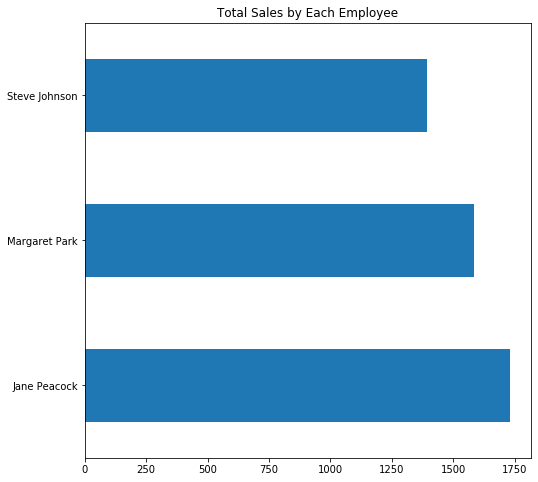

In [6]:
df = run_query(q)
df = df.set_index('employee_name', drop=True)
df['total'].plot.barh(figsize=(8,8), title='Total Sales by Each Employee')
plt.ylabel('')

Jane Peacock has contributed to 20% more sales compared to the lowest earning employee. But this difference in sales can be attributed to the difference in hiring dates.

## Analyzing sales by country
Our next goal is to collect data on purchases from different countries. When a country has only 1 customer, collect them into 'Other' group. The result should contain the following columns - total number of customers, total value of sales, average sales per customer and average order value. Sort the results by total sales in descending and put 'Others' at the bottom.

In [7]:
q = '''WITH 
         country_count AS
                     (
                     SELECT 
                         country, 
                         COUNT(customer_id) 'total_customers'
                    FROM customer 
                    GROUP BY 1
                    ),
        new_customer_table AS
                    (
                    SELECT c.*,
                           CASE
                               WHEN cc.total_customers = 1 THEN 'Others'
                               ELSE cc.country
                               END AS updated_country
                    FROM customer c
                    LEFT JOIN country_count cc ON cc.country = c.country
                    ),
        customer_sales_table AS
                    (
                    SELECT 
                        nct.updated_country country, 
                        COUNT(DISTINCT(nct.customer_id)) total_customers,
                        SUM(i.total) 'total_sales',
                        SUM(i.total)/COUNT(DISTINCT(nct.customer_id)) avg_sales_per_customer,
                        SUM(i.total)/COUNT(i.invoice_id) avg_order_value,
                        COUNT(i.invoice_id)
                    FROM new_customer_table nct
                    LEFT JOIN invoice i ON i.customer_id = nct.customer_id
                    GROUP BY 1
                    )
                    
        SELECT 
            country,
            total_customers,
            total_sales,
            avg_sales_per_customer,
            avg_order_value
        FROM 
            (
            SELECT 
                cst.*,
                CASE
                    WHEN cst.country = 'Others' THEN 1
                    ELSE 0
                    END AS sort
            FROM customer_sales_table cst
            )
        ORDER BY sort, total_sales DESC
        '''
run_query(q)

,country,total_customers,total_sales,avg_sales_per_customer,avg_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Others,15,1094.94,72.996000,7.448571


## Visualizing Sales by Country

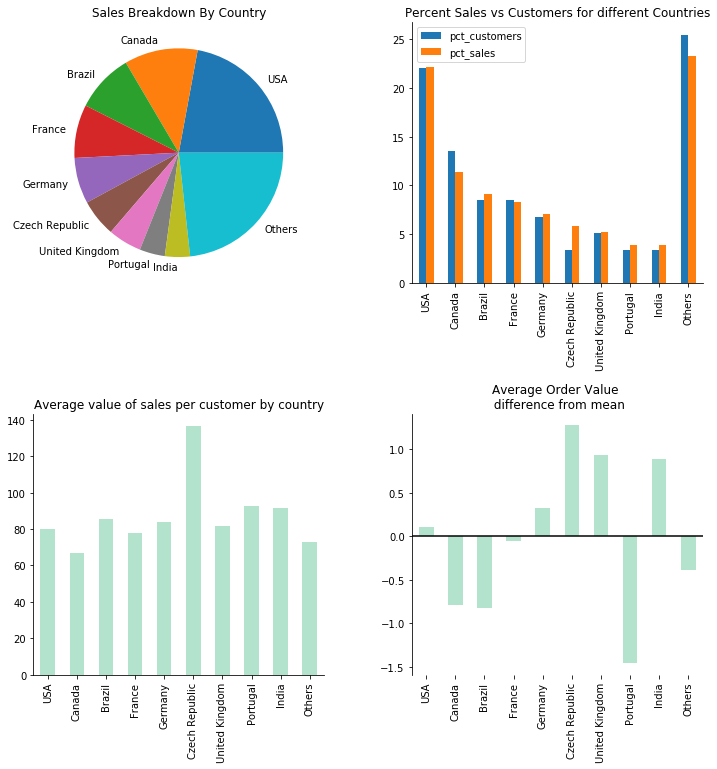

In [8]:
sales_country = run_query(q)
sales_country.set_index('country', inplace=True, drop=True)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (12,12))
fig.subplots_adjust(hspace=.5, wspace=.3)

sales_country['total_sales'].plot.pie(ax=ax1)
ax1.set_title('Sales Breakdown By Country')
ax1.set_ylabel('')

sales_country['pct_customers'] = (sales_country['total_customers']/sales_country['total_customers'].sum())*100
sales_country['pct_sales'] = (sales_country['total_sales']/sales_country['total_sales'].sum())*100

cols = ['pct_customers', 'pct_sales']
sales_country[cols].plot.bar(ax=ax2)
ax2.set_title('Percent Sales vs Customers for different Countries')
ax2.set_xlabel('')
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

sales_country['avg_sales_per_customer'].plot.bar(ax=ax3, cmap='Pastel2')
ax3.set_title('Average value of sales per customer by country')
ax3.set_xlabel('')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)

sales_country['avg_order_from_mean'] = sales_country['avg_order_value'] - sales_country['avg_order_value'].mean()
sales_country['avg_order_from_mean'].plot.bar(ax=ax4, cmap='Pastel2')
ax4.set_title('Average Order Value \n difference from mean')
ax4.set_xlabel('')
ax4.tick_params(bottom="off")
ax4.axhline(0, color='k')
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
ax4.spines['bottom'].set_visible(False)

Based on the data, Czech Republic, India and United Kingdom have the highest potential for growth (less customers but high average orders).It is important to know that the sample size in this case is not big enough to be absolutely sure of the trendlines. A better way to go about it would be to spend a little money in these regions for marketing, collect more data and check to see if the trend is followed by the new customers.

## Album vs Individual Tracks
Our next goal is to write a query that categorizes each invoice as either an album purchase or not, and calculates - number of invoices and percentage of invoices

In [18]:
invoice_line = '''WITH 
                      invoice_track AS
                            (
                            SELECT invoice_id, 
                                   COUNT(track_id) total_tracks_bought, 
                                   MIN(track_id) min_track_id 
                            FROM invoice_line
                            GROUP BY 1
                            ),
                     invoices AS
                            (
                            SELECT il.invoice_id,
                                   il.track_id,
                                   it.total_tracks_bought,
                                   it.min_track_id
                            FROM invoice_line il
                            LEFT JOIN invoice_track it ON it.invoice_id = il.invoice_id
                            ),
                    track_album_count AS
                            (
                            SELECT 
                                COUNT(track_id) total_tracks, 
                                MIN(track_id) min_track_id, 
                                name, 
                                album_id 
                            FROM track 
                            GROUP BY 4
                            ),
                    new_track AS
                            (
                            SELECT
                                t.track_id,
                                tac.*
                            FROM track t
                            LEFT JOIN track_album_count tac ON tac.album_id = t.album_id 
                            )
              
              SELECT
                  album_purchase,
                  COUNT(invoice_id) total,
                  CAST(COUNT(invoice_id) AS Float)/(SELECT COUNT(invoice_id) FROM invoice_track) percent
              FROM
              (
              SELECT it.*,
                  CASE
                    WHEN
                        (
                        SELECT i.track_id FROM invoices i
                        WHERE i.invoice_id = it.invoice_id
    
                        EXCEPT
                        
                        SELECT nt.track_id from new_track nt
                        WHERE nt.album_id = (
                                            SELECT nt.album_id FROM new_track nt
                                            WHERE nt.min_track_id = it.min_track_id
                                            )
                        )
                        IS NULL
                      AND
                        (
                        SELECT nt2.track_id from new_track nt2
                        WHERE nt2.album_id = (
                                              SELECT nt.album_id FROM new_track nt
                                              WHERE nt.min_track_id = it.min_track_id
                                              )
                        
                       EXCEPT
        
                          SELECT i.track_id FROM invoices i
                          WHERE i.invoice_id = it.invoice_id
                       )
                       IS NULL
                  THEN "yes"
                  ELSE "no"
             END AS "album_purchase"
             FROM invoice_track it
            )
            GROUP BY album_purchase  
           '''

display(run_query(invoice_line))

,album_purchase,total,percent
0,no,500,0.814332
1,yes,114,0.185668


Over 81% of the purchases are non-album purchases. However, it is still recommended to buy full albums from record stores or we might end up losing 19% of the revenue.